In [1]:
# Standard libraries
import json
import os

# Third party packages
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, ViTImageProcessor, VisionEncoderDecoderModel

# Reproducibility
np.random.seed(42)
torch.manual_seed(42)

In [2]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

smooth_fn = SmoothingFunction().method1

In [3]:
# GPU setup
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


## Dataset loading

In [4]:
# Download dataset
data_path = kagglehub.dataset_download(
    "nagasai524/mini-coco2014-dataset-for-image-captioning")

In [5]:
def load_captions(dataset_path):
    """Load image_id -> list of captions mapping from captions.json."""
    captions_path = os.path.join(dataset_path, "captions.json")
    with open(captions_path, "r") as f:
        data = json.load(f)

    annotations = data["annotations"] if isinstance(data, dict) else data

    captions = {}
    for ann in annotations:
        img_id = ann["image_id"]
        captions.setdefault(img_id, []).append(ann["caption"])
    return captions

In [6]:
def find_image_folder(dataset_path, ext=".jpg"):
    """Find first folder under dataset_path that contains image files."""
    for root, _, files in os.walk(dataset_path):
        if any(f.lower().endswith(ext) for f in files):
            return root
    raise RuntimeError(f"No image folder with *{ext} found under {dataset_path}")

In [7]:
captions = load_captions(data_path)
img_folder = find_image_folder(data_path)
img_ids = sorted(captions.keys())

print(f"Dataset loaded, {len(img_ids)} images with captions")

Dataset loaded, 18783 images with captions


In [8]:
def get_image(idx):
    """Load image and its captions by index in img_ids."""
    img_id = img_ids[idx]

    # Try common filename patterns
    candidates = [
        os.path.join(img_folder, f"COCO_train2014_{img_id:012d}.jpg"),
        os.path.join(img_folder, f"{img_id}.jpg"),
    ]

    for img_path in candidates:
        if os.path.exists(img_path):
            img = Image.open(img_path).convert("RGB")
            return img, captions[img_id]

    raise FileNotFoundError(f"No image file found for image_id {img_id}")


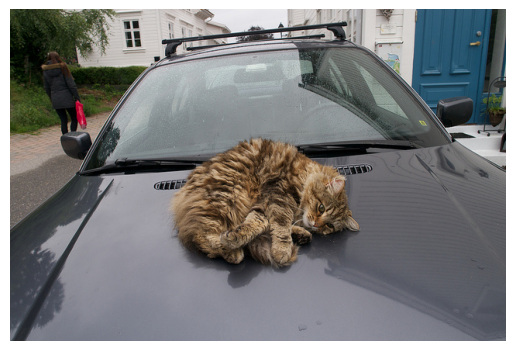

Image index: 6000, image_id: 190360
Ground truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [9]:
# Choose an image to show
idx = 6000

img, caps = get_image(idx)

plt.imshow(img)
plt.axis("off")
plt.show()

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("Ground truth captions:")
for cap in caps:
    print(f"  - {cap}")


## Baseline model loading

In [10]:
model_name = "nlpconnect/vit-gpt2-image-captioning"

model = VisionEncoderDecoderModel.from_pretrained(
    model_name,
    attn_implementation="eager").to(device)

feature_extractor = ViTImageProcessor.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model.eval()

print(f"Loaded model: {model_name}")
print(f"Decoder attention implementation: {model.config.decoder._attn_implementation}")

Loaded model: nlpconnect/vit-gpt2-image-captioning
Decoder attention implementation: eager


## Functions for caption & attention generations

In [11]:
@torch.no_grad()
def generate_caption_and_attention(img, max_length=16):
    """
    Generate a caption for a PIL image and return:
    - caption (str)
    - cross_attentions (list of tensors)
    - encoder_hidden_states (tensor)
    - setting max length of generated caption to 16
    """
    # Image -> pixel_values
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)

    # Encode image: hidden states as visual feature grid that decoder will attend to 
    encoder_outputs = model.encoder(pixel_values=pixel_values)
    encoder_hidden_states = encoder_outputs.last_hidden_state  # [1, 197, hidden_dim]

    # Generate caption ids
    generated_ids =model.generate(
        pixel_values,
        max_length=max_length,
        do_sample=False, 
        use_cache=False)


    # Run decoder once over full sequence (generated caption) to get cross-attentions
    #output_attentions = True to get cross-attention weights for all decoder layers
    #decoder_outputs.cross_attentions as tuple with cross-attention weights from each layer (in gpt2 as decoder this means 12 layers)
    decoder_outputs = model.decoder(
        input_ids=generated_ids,
        encoder_hidden_states=encoder_hidden_states,
        output_attentions=True,
        return_dict=True,
        use_cache=False)
    #turn IDs into string caption
    caption = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    #returning caption, raw cross-attention tensor for all layers and all tokens and encoder_hidden_states as visual token grid
    return caption, decoder_outputs.cross_attentions, encoder_hidden_states


In [12]:
def aggregate_cross_attention(cross_attentions, img_size, patch_size=14):
    """
    Aggregate cross-attention over heads and tokens into a 2D heatmap
    in image resolution (sentence-based aggregation).
    
    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    """
    # Take last decoder layer (most informative)
    last_layer = cross_attentions[-1]          # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)         # [num_heads, tgt_len, src_len]

    # Average over heads and decoder tokens
    avg_over_heads = last_layer.mean(dim=0)    # [tgt_len, src_len] #average across attention heads
    avg_over_tokens = avg_over_heads.mean(dim=0)  # [src_len] #average over all decoder tokens: sentence-based attack as we average attiont weights over all generated words

    # Drop CLS token and keep only patch tokens
    patch_attention = avg_over_tokens[1:]      # removing CLS token [patch_size^2], only keeping patch tokens

    # Reshape to patch grid
    attention_map = patch_attention.reshape(patch_size, patch_size).cpu().numpy()

    # Normalize to [0, 1]
    attention_map -= attention_map.min()
    denom = attention_map.max() if attention_map.max() > 0 else 1e-8
    attention_map /= denom

    # Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    #result: pixel-level attention map aligned with original image
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

In [13]:
def aggregate_word_based_attention(cross_attentions, img_size, k_per_token=10, patch_size=14):
    """
    Word-based (token-based) aggregation:
    - For each decoder token, look at its cross-attention over image patches.
    - Select the top-k patches for that token.
    - Aggregate these selections across tokens into a single patch-level map.
    - Upsample to image size and return a [H, W] heatmap in [0, 1].

    cross_attentions: list of tensors, each [1, num_heads, tgt_len, src_len]
                      src_len = 1 (CLS) + patch_size^2
    img_size: (width, height) of the original image
    k_per_token: how many patches to keep per token
    """

    # 1) Take last decoder layer (like in sentence-based version)
    last_layer = cross_attentions[-1]       # [1, num_heads, tgt_len, src_len]
    last_layer = last_layer.squeeze(0)      # [num_heads, tgt_len, src_len]

    num_heads, tgt_len, src_len = last_layer.shape
    assert src_len == 1 + patch_size * patch_size, "Unexpected src_len for given patch_size"

    # 2) Prepare an accumulator for patch scores: one value per patch
    #    We'll use 'max' over tokens as our aggregation.
    device = last_layer.device
    patch_scores = torch.zeros(patch_size * patch_size, device=device)

    for t in range(tgt_len):
        # Cross-attention for this token: [num_heads, src_len]
        token_attn = last_layer[:, t, :]          # [num_heads, src_len]

        # Average over heads -> [src_len]
        avg_over_heads = token_attn.mean(dim=0)   # [src_len]

        # Drop CLS (index 0), keep only ViT patch tokens -> [patch_size^2]
        patch_attn = avg_over_heads[1:]           # [patch_size^2]

        # Normalize this token's patch attention to [0,1]
        pa = patch_attn - patch_attn.min()
        denom = pa.max() if pa.max() > 0 else 1e-8
        pa = pa / denom

        # Select top-k patches for this token
        k = min(k_per_token, pa.numel())
        top_vals, top_idx = torch.topk(pa, k)

        # Aggregate into patch_scores: take maximum across tokens
        patch_scores[top_idx] = torch.maximum(patch_scores[top_idx], top_vals)

    # 3) Normalize aggregated patch_scores to [0, 1]
    ps = patch_scores - patch_scores.min()
    denom = ps.max() if ps.max() > 0 else 1e-8
    ps = ps / denom

    # 4) Reshape to patch grid
    attention_map = ps.reshape(patch_size, patch_size).detach().cpu().numpy()

    # 5) Upsample to original image size
    w, h = img_size
    attn_img = Image.fromarray((attention_map * 255).astype(np.uint8))
    attn_resized = attn_img.resize((w, h), resample=Image.BICUBIC)

    return np.array(attn_resized) / 255.0

## Displaying example image

In [14]:
def show_image_and_attention(img, caption, attention_heatmap):
    """Plot original image, attention heatmap, and overlay."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # 1) Original image
    axes[0].imshow(img)
    axes[0].set_title(f"Original image\nCaption: '{caption}'", fontsize=10)
    axes[0].axis("off")

    # 2) Heatmap only
    axes[1].imshow(attention_heatmap, cmap="hot")
    axes[1].set_title("Cross-attention heatmap", fontsize=10)
    axes[1].axis("off")

    # 3) Overlay
    axes[2].imshow(img)
    axes[2].imshow(attention_heatmap, cmap="hot", alpha=0.5)
    axes[2].set_title("Attention overlay\n(red = high attention)", fontsize=10)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


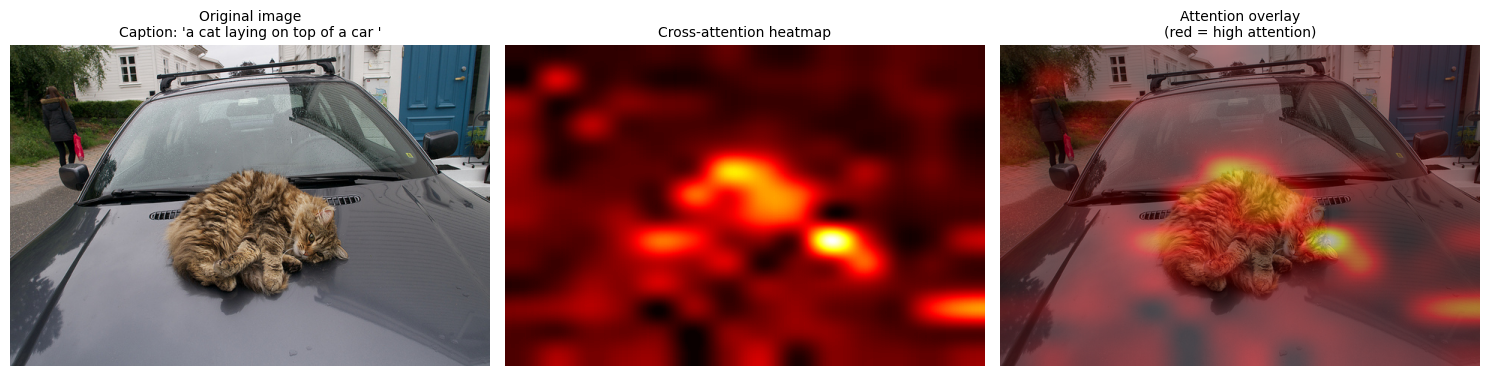

Image index: 6000, image_id: 190360

Ground-truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [15]:
img, gt_caps = get_image(idx)

caption, cross_attentions, _ = generate_caption_and_attention(img)
attention_heatmap = aggregate_cross_attention(cross_attentions, img.size)

show_image_and_attention(img, caption, attention_heatmap)

print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")

Sentence-based attention:


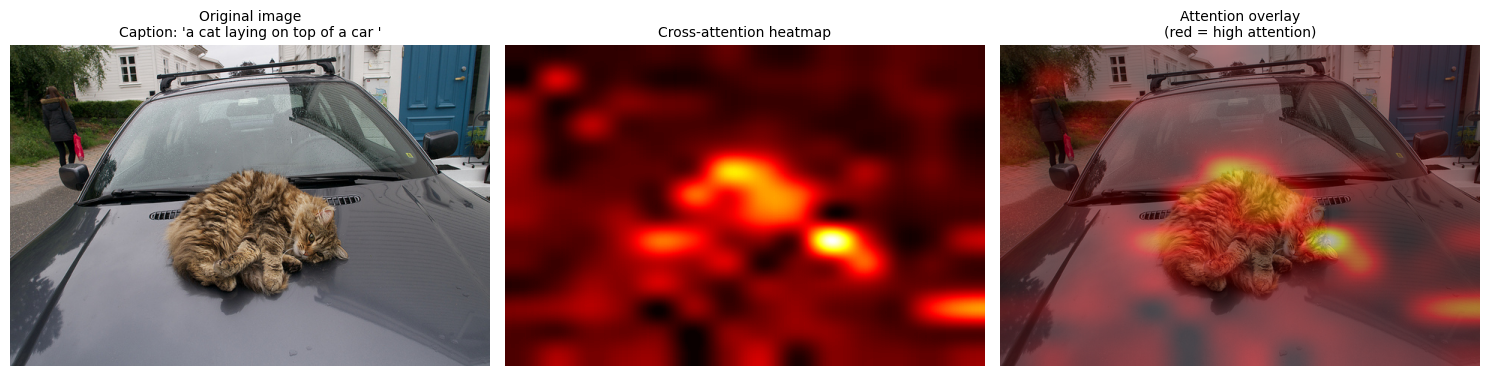

Word-based attention (aggregated across tokens):


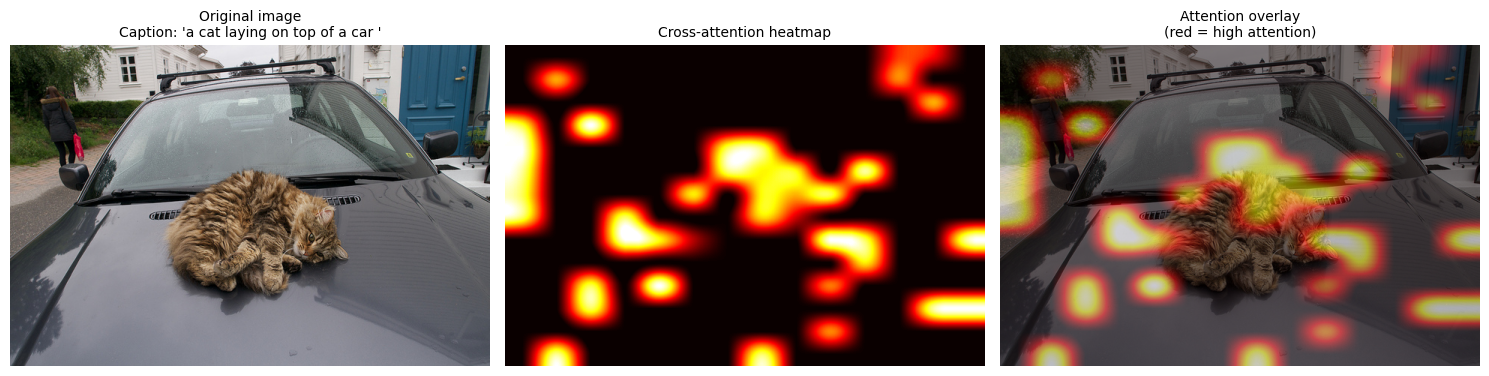

Image index: 6000, image_id: 190360

Ground-truth captions:
  - A fluffy cat sleeping on the hood of a car
  - A cat is laying on a car parked in a road in front of houses with a person standing in the background
  - A cat is lying awake on a car hood
  - The cat is lying down on top of a black car
  - Cat relaxing on the hood of a car in an alley


In [16]:
# 1) Get image and its GT captions
img, gt_caps = get_image(idx)

# 2) Get caption + cross-attentions (using your existing function, slightly extended if needed)
caption, cross_attentions, _ = generate_caption_and_attention(img)

# 3) Sentence-based heatmap (for comparison, existing code)
sentence_heatmap = aggregate_cross_attention(cross_attentions, img.size)

# 4) Word-based heatmap using new function
word_based_heatmap = aggregate_word_based_attention(
    cross_attentions,
    img_size=img.size,
    k_per_token=10,       # tweak this hyperparameter
    patch_size=14
)

# 5) Visualize sentence-based vs word-based (two separate calls)
print("Sentence-based attention:")
show_image_and_attention(img, caption, sentence_heatmap)

print("Word-based attention (aggregated across tokens):")
show_image_and_attention(img, caption, word_based_heatmap)

# 6) Ground-truth captions for reference
print(f"Image index: {idx}, image_id: {img_ids[idx]}")
print("\nGround-truth captions:")
for cap in gt_caps:
    print(f"  - {cap}")


## Identifying candidate region

In [17]:
def get_topk_candidate_pixels(attention_heatmap, k):
    """
    Select top-k pixels with highest attention as candidate region.
    Returns list of (y, x) indices.
    """
    flat = attention_heatmap.flatten()
    #note: attention map can either be sentence-based or word-based depending on what we give as input
    k = min(k, flat.size)
    idxs = np.argpartition(flat, -k)[-k:]
    ys, xs = np.unravel_index(idxs, attention_heatmap.shape)
    #x and y as search space for differential evolution
    return list(zip(ys, xs))

#visualization of candidate region
def show_candidate_region(img, attention_heatmap, candidate_pixels):
    """
    Visualize original image and candidate region (pixels we may perturb).
    """
    mask = np.zeros(attention_heatmap.shape, dtype=bool)
    for y, x in candidate_pixels:
        mask[y, x] = True

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Original image
    axes[0].imshow(img)
    axes[0].set_title("Original image")
    axes[0].axis("off")

    # Candidate overlay
    axes[1].imshow(img)
    axes[1].imshow(mask, cmap="Reds", alpha=0.6)
    axes[1].set_title("Candidate region (pixels we may perturb)")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

## Configurations Attack

In [48]:
# Attack configuration
ATTACK_CFG = {
    "attack_idx": 6000,        # example image index
    "k_pixels": 500,           # candidate pixels
    "pop_size": 20,
    "generations": 20,
    "F": 0.6,
    "CR": 0.7,
    "eps": 40.0,
    "lambda_reg": 0.0,         # no regularization at first
    "random_seed": 42,
}


## Sentence based attack: candidate region

Attack index: 6000
Base caption: 'a cat laying on top of a car '
Number of candidate pixels: 500


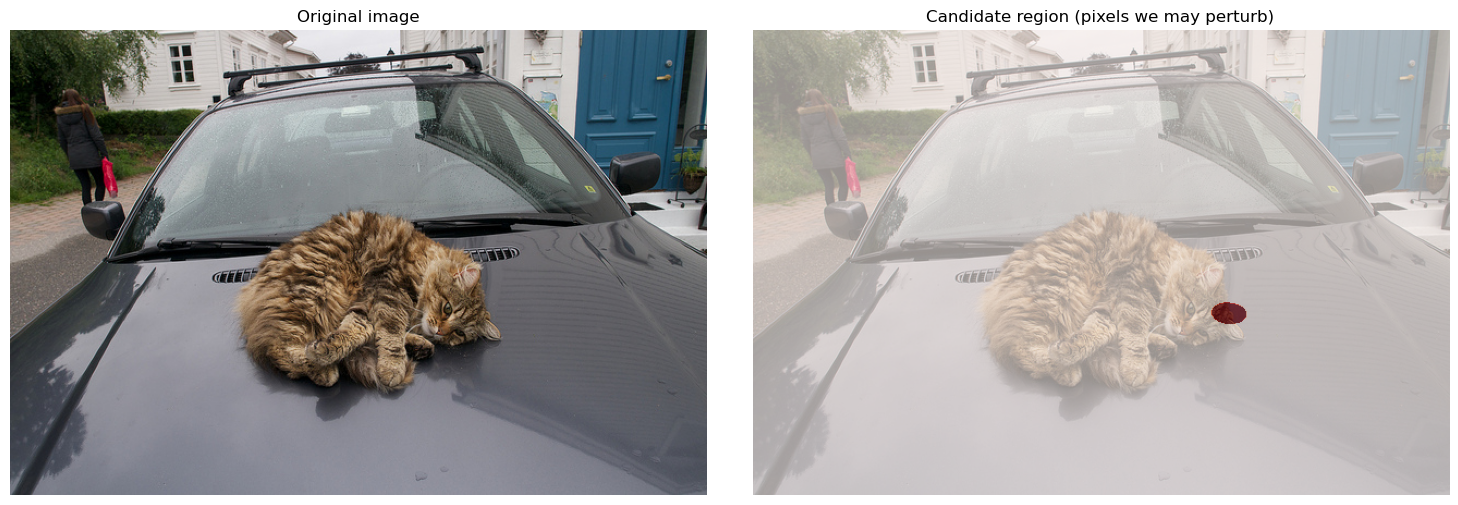

In [49]:
# Image and Ground Truth Captions (gt_caps)
base_img, gt_caps = get_image(idx)

#getting caption and cross attention for base image
base_caption, cross_attentions, _ = generate_caption_and_attention(base_img)

#aggregate cross attention - this is sentence-based (could be changed to word-based)
attention_heatmap = aggregate_cross_attention(cross_attentions, base_img.size)

#setting candidate pixels to top 35000 pixels in attention heatmap; configure differently if needed
candidate_pixels = get_topk_candidate_pixels(attention_heatmap, ATTACK_CFG["k_pixels"])

print(f"Attack index: {ATTACK_CFG["attack_idx"]}")
print(f"Base caption: '{base_caption}'")
print(f"Number of candidate pixels: {len(candidate_pixels)}")

#visualizing candidate region
show_candidate_region(base_img, attention_heatmap, candidate_pixels)


## Word based attack: candidate regions

Attack index: 6000
Base caption: 'a cat laying on top of a car '
Number of candidate pixels: 500


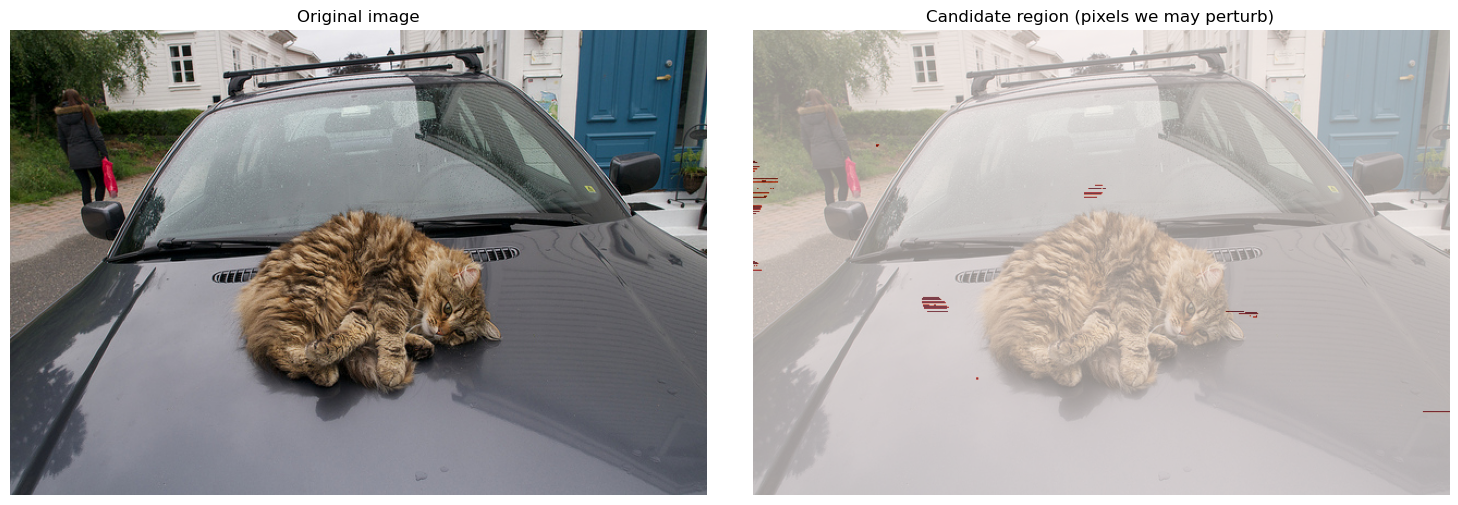

In [50]:
#same attack simulation as before but word-based attention instead of sentence based
ATTACK_IDX = ATTACK_CFG["attack_idx"]

#aggregate cross attention - this is sentence-based (could be changed to word-based)
attention_heatmap_word = aggregate_word_based_attention(cross_attentions, base_img.size)

#setting candidate pixels to top 35000 pixels in attention heatmap; configure differently if needed
candidate_pixels_word = get_topk_candidate_pixels(attention_heatmap_word, ATTACK_CFG["k_pixels"])

print(f"Attack index: {ATTACK_IDX}")
print(f"Base caption: '{base_caption}'")
print(f"Number of candidate pixels: {len(candidate_pixels_word)}")

#visualizing candidate region
show_candidate_region(base_img, attention_heatmap_word, candidate_pixels_word)


In [51]:
def image_to_array(img):
    """Convert PIL image to uint8 numpy array of shape (H, W, 3)."""
    return np.array(img).astype(np.uint8)


def array_to_image(arr):
    """Convert numpy array (H, W, 3) back to PIL image."""
    return Image.fromarray(arr.astype(np.uint8))


def apply_perturbation(base_array, delta_vec, candidate_pixels):
    #for each candidate pixel, you have 3 values (change in R, G, B)
    #candidate pixels as pixel coordinates from candidate region from attention
    """
    Apply a perturbation vector to the candidate pixels of an image.
    
    base_array: numpy array (H, W, 3), uint8
    delta_vec: 1D numpy array of length 3 * len(candidate_pixels)
               [dR1, dG1, dB1, dR2, dG2, dB2, ...]
    candidate_pixels: list of (y, x) positions
    """
    H, W, C = base_array.shape
    assert C == 3, "Expected RGB image"
    num_pixels = len(candidate_pixels)
    assert delta_vec.shape[0] == 3 * num_pixels, "delta_vec length mismatch"

    # work on a float copy so we can add positive/negative deltas
    perturbed = base_array.astype(np.float32).copy()
    deltas = delta_vec.reshape(num_pixels, 3)

    #this is where acutal attack perturbation is applied
    for (y, x), d in zip(candidate_pixels, deltas):
        # add deltas to this pixel (R,G,B)
        perturbed[y, x, :] += d

    # clipping back to valid image range (adding delta might make range go beyond 0, 255)
    perturbed = np.clip(perturbed, 0, 255).astype(np.uint8)
    #output: perturbed image with same type and same resolution
    return array_to_image(perturbed)


# base image as numpy array (used for all perturbations)
base_array = image_to_array(base_img)

#base_array as original clean image
#delta_vec as attack vector from DE algorithm 
#apply perturbation to get perturbed image restricted to candidate region

In [52]:
def generate_caption(img, max_length=16):
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    generated_ids = model.generate(pixel_values, max_length=max_length, num_beams=1)
    return tokenizer.decode(generated_ids[0], skip_special_tokens=True)

def bleu_score(ref_captions, pred_caption):
    """
    Compute BLEU-4 between list of GT captions and predicted caption.
    ref_captions: list[str]
    pred_caption: str
    """
    if isinstance(ref_captions, str):
        ref_captions = [ref_captions]
    refs = [c.lower().split() for c in ref_captions]
    hyp = pred_caption.lower().split()
    # sentence_bleu returns BLEU in [0,1]; we keep it like that
    return sentence_bleu(refs, hyp, smoothing_function=smooth_fn)

In [22]:
def differential_evolution(
    fitness_fn,
    dim,
    pop_size=8,
    generations=5,
    F=0.5,
    CR=0.7,
    eps=20.0,
    random_seed=42):
    """
    Very simple Differential Evolution (DE/rand/1/bin).
    
    fitness_fn: function x -> scalar (higher = better)
    dim: dimensionality of x (here: 3 * len(candidate_pixels))
    pop_size: number of individuals in the population
    generations: number of DE generations
    F: mutation factor
    CR: crossover rate
    eps: initial range for parameters: x ~ U[-eps, +eps]
    """
    rng = np.random.default_rng(random_seed)

    #Initializing population with random vectors
    pop = rng.uniform(low=-eps, high=eps, size=(pop_size, dim)).astype(np.float32)
    fitness_vals = np.array([fitness_fn(ind) for ind in pop], dtype=np.float32)
    #at this point, we know how good the initial random perturbations are
    best_idx = int(np.argmax(fitness_vals))
    best_x = pop[best_idx].copy()
    best_f = float(fitness_vals[best_idx])

    print(f"Initial best fitness: {best_f:.4f}")

    # 2) Iterate over generations; each generation is refinement step
    for gen in range(generations):
        print(f"\n--- Generation {gen + 1}/{generations} ---")

        for i in range(pop_size):
            # Choose indices for mutation (a, b, c all different and all != i)
            idxs = list(range(pop_size))
            idxs.remove(i)
            a, b, c = rng.choice(idxs, size=3, replace=False)

            x_a, x_b, x_c = pop[a], pop[b], pop[c]

            # Mutation: v = x_a + F * (x_b - x_c); new candidate direction is x_b-X_c; step from x_a in that direction and scale by F
            #v as new perturbation that combines information from 3 other perturbations
            v = x_a + F * (x_b - x_c)

            # Crossover: binomial; create trial vector u from v and current individual pop[i]
            cross_mask = rng.random(dim) < CR
            # Ensure at least one component comes from v
            j_rand = rng.integers(0, dim)
            cross_mask[j_rand] = True

            u = np.where(cross_mask, v, pop[i])

            # Evaluate trial vector
            f_u = fitness_fn(u)

            # Selection: keep trial if it is better
            if f_u > fitness_vals[i]:
                pop[i] = u
                fitness_vals[i] = f_u

                # Update global best if necessary
                if f_u > best_f:
                    best_f = float(f_u)
                    best_x = u.copy()

        print(f"Best fitness after generation {gen + 1}: {best_f:.4f}")

    return best_x, best_f

In [25]:
#taking one image from dataset, setting hyperaparameters for DE attack with lambda regularizing how strongly to penalize large perturbations
def run_bleu_attack(idx, candidate_pixels,
                    cfg):
    """
    Perform a BLEU-based AIC attack on image `idx` using Differential Evolution.
    
    idx: index into img_ids
    candidate_pixels: list of (y, x) pixel coordinates to perturb
    pop_size: DE population size
    generations: number of DE generations
    F, CR: DE hyperparameters
    eps: initial sampling range for perturbation values
    lambda_reg: regularization strength for perturbation size

    Returns:
        result dict with base/adv images, captions, BLEU scores, best_x, etc.
    """
    pop_size    = cfg["pop_size"]
    generations = cfg["generations"]
    F           = cfg["F"]
    CR          = cfg["CR"]
    eps         = cfg["eps"]
    lambda_reg  = cfg["lambda_reg"]
    random_seed = cfg["random_seed"]
    
    #getting image and groud truth captions
    base_img, gt_caps = get_image(idx)
    print(f"Loaded image {idx} with {len(gt_caps)} ground-truth captions")

    #calculating bleu of original caption
    base_caption = generate_caption(base_img)
    base_bleu = bleu_score(gt_caps, base_caption)
    print(f"Base caption: '{base_caption}'")
    print(f"Base BLEU-4 wrt GT captions: {base_bleu:.4f}")

    #defining search space for perturbation based on attention-absed candidate pixels
    base_array = image_to_array(base_img)
    num_pixels = len(candidate_pixels)
    dim = 3 * num_pixels  # 3 channels per pixel
    print(f"Number of candidate pixels: {num_pixels}")
    print(f"Dimension of perturbation vector: {dim}")

    #define fitness function for DE
    #fitness consists of both belu drop and norm of perturbation because we want perturbation to be small
    #fitness is what DE wants to maximize
    def fitness(x):
        #DE algorithm will call this again and again for different x values
        """
        x: 1D numpy array with length 3 * len(candidate_pixels)
        returns: scalar, higher = better attack 
                 (larger BLEU drop and smaller perturbation)
        """
        # Build perturbed image from x
        perturbed_img = apply_perturbation(base_array, x, candidate_pixels)

        # Generate caption for perturbed image
        adv_caption = generate_caption(perturbed_img)

        # BLEU after attack
        adv_bleu = bleu_score(gt_caps, adv_caption)

        # BLEU drop (we want this large)
        bleu_drop = base_bleu - adv_bleu

        # Normalized L2 norm of perturbation (we want this small)
        norm = np.linalg.norm(x) / (255.0 * np.sqrt(x.size))

        # Maximize BLEU drop - λ * norm; return as fitness score
        return bleu_drop - lambda_reg * norm

    # --- 5) Sanity checks on fitness ---
    x_zero = np.zeros(dim, dtype=np.float32)
    score_zero = fitness(x_zero)
    print(f"Fitness(x_zero) (no perturbation): {score_zero:.4f}")

    rng = np.random.default_rng(42)
    x_rand = rng.uniform(low=-eps, high=eps, size=dim).astype(np.float32)
    score_rand = fitness(x_rand)
    print(f"Fitness(x_rand) (random perturbation): {score_rand:.4f}")

    # --- 6) Run Differential Evolution ---
    best_x, best_f = differential_evolution(
        fitness_fn=fitness,
        dim=dim,
        pop_size=pop_size,
        generations=generations,
        F=F,
        CR=CR,
        eps=eps,
        random_seed=42,
    )

    print("\n=== Differential Evolution finished ===")
    print(f"Best fitness found: {best_f:.4f}")

    #building adversarial image from best perturbation
    adv_img = apply_perturbation(base_array, best_x, candidate_pixels)
    adv_caption = generate_caption(adv_img)
    adv_bleu = bleu_score(gt_caps, adv_caption)

    print(f"\nOriginal caption : '{base_caption}'")
    print(f"Adversarial cap. : '{adv_caption}'")
    print(f"Base BLEU        : {base_bleu:.4f}")
    print(f"Adversarial BLEU : {adv_bleu:.4f}")
    print(f"BLEU drop        : {base_bleu - adv_bleu:.4f}")

    return {
        "base_img": base_img,
        "adv_img": adv_img,
        "base_caption": base_caption,
        "adv_caption": adv_caption,
        "base_bleu": base_bleu,
        "adv_bleu": adv_bleu,
        "bleu_drop": base_bleu - adv_bleu,
        "best_x": best_x,
        "best_fitness": best_f,
        "gt_caps": gt_caps,
    }


Loaded image 6000 with 5 ground-truth captions
Base caption: 'a cat laying on top of a car '
Base BLEU-4 wrt GT captions: 0.4775
Number of candidate pixels: 500
Dimension of perturbation vector: 1500
Fitness(x_zero) (no perturbation): 0.0000
Fitness(x_rand) (random perturbation): -0.0002
Initial best fitness: -0.0002

--- Generation 1/3 ---
Best fitness after generation 1: -0.0002

--- Generation 2/3 ---
Best fitness after generation 2: -0.0002

--- Generation 3/3 ---
Best fitness after generation 3: -0.0002

=== Differential Evolution finished ===
Best fitness found: -0.0002

Original caption : 'a cat laying on top of a car '
Adversarial cap. : 'a cat laying on top of a car '
Base BLEU        : 0.4775
Adversarial BLEU : 0.4775
BLEU drop        : 0.0000


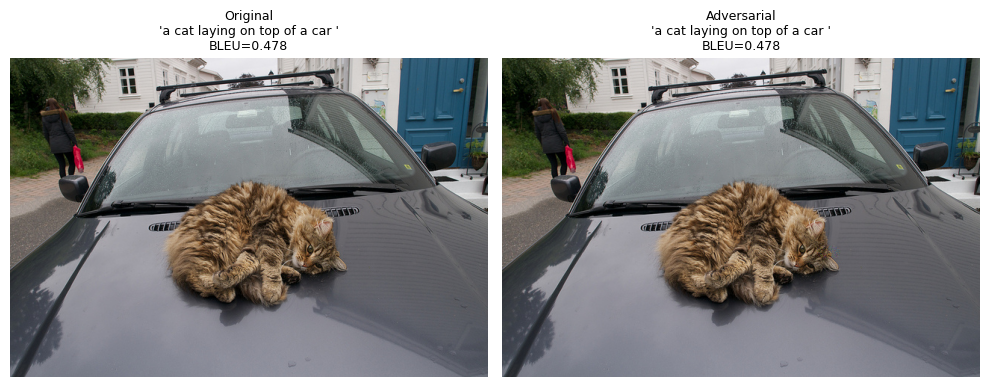

In [33]:
result = run_bleu_attack(
    idx=ATTACK_IDX,
    candidate_pixels=candidate_pixels,
    pop_size=6,
    generations=3,
    F=0.6,
    CR=0.7,
    eps=20.0,
    lambda_reg=0.005,
)

base_img = result["base_img"]
adv_img = result["adv_img"]
base_caption = result["base_caption"]
adv_caption = result["adv_caption"]
base_bleu = result["base_bleu"]
adv_bleu = result["adv_bleu"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(base_img)
plt.title(f"Original\n'{base_caption}'\nBLEU={base_bleu:.3f}", fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"Adversarial\n'{adv_caption}'\nBLEU={adv_bleu:.3f}", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()


Conclusion for now: current setup not strong enough to trigger change - experimenting with alternative solutions

1st experiment: using loss function of model instead of BLEU scores for fitness

In [40]:
@torch.no_grad()
def caption_loss(img, base_ids):
    """
    Compute cross-entropy loss of generating the base caption.
    Higher loss = worse fit = better attack.
    """
    pixel_values = feature_extractor(images=img, return_tensors="pt").pixel_values.to(device)
    output = model(pixel_values=pixel_values, labels=base_ids)
    return output.loss.item()

base_caption = generate_caption(base_img)

# Tokenize base caption for loss computation
base_ids = tokenizer(
    base_caption,
    return_tensors="pt",
    add_special_tokens=True,
).input_ids.to(device)
base_loss = caption_loss(base_img, base_ids)
# Define your loss-based fitness function
def fitness_loss_based(x):
    perturbed_img = apply_perturbation(base_array, x, candidate_pixels)
    adv_loss = caption_loss(perturbed_img, base_ids)
    return adv_loss - base_loss


def fitness_loss_based(x):
    """
    Fitness = increase in caption loss compared to base image.
    Higher is better (more mismatch between image and caption).
    """
    perturbed_img = apply_perturbation(base_array, x, candidate_pixels)
    adv_loss = caption_loss(perturbed_img, base_ids)
    return adv_loss - base_loss  # max increase in loss


In [45]:
#taking one image from dataset, setting hyperaparameters for DE attack with lambda regularizing how strongly to penalize large perturbations
def run_loss_attack(idx, candidate_pixels,
                    pop_size=6, generations=3,
                    F=0.6, CR=0.7, eps=20.0,
                    lambda_reg=0.005):
    """
    Perform a BLEU-based AIC attack on image `idx` using Differential Evolution.
    
    idx: index into img_ids
    candidate_pixels: list of (y, x) pixel coordinates to perturb
    pop_size: DE population size
    generations: number of DE generations
    F, CR: DE hyperparameters
    eps: initial sampling range for perturbation values
    lambda_reg: regularization strength for perturbation size

    Returns:
        result dict with base/adv images, captions, BLEU scores, best_x, etc.
    """

    #getting image and groud truth captions
    base_img, gt_caps = get_image(idx)
    print(f"Loaded image {idx} with {len(gt_caps)} ground-truth captions")

    #calculating bleu of original caption
    base_caption = generate_caption(base_img)
    base_bleu = bleu_score(gt_caps, base_caption)
    print(f"Base caption: '{base_caption}'")
    print(f"Base BLEU-4 wrt GT captions: {base_bleu:.4f}")

    #defining search space for perturbation based on attention-absed candidate pixels
    base_array = image_to_array(base_img)
    num_pixels = len(candidate_pixels)
    dim = 3 * num_pixels  # 3 channels per pixel
    print(f"Number of candidate pixels: {num_pixels}")
    print(f"Dimension of perturbation vector: {dim}")

    #define fitness function for DE
    #fitness consists of both belu drop and norm of perturbation because we want perturbation to be small
    #fitness is what DE wants to maximize
    def fitness(x):
        #DE algorithm will call this again and again for different x values
        """
        x: 1D numpy array with length 3 * len(candidate_pixels)
        returns: scalar, higher = better attack 
                 (larger BLEU drop and smaller perturbation)
        """
        # Build perturbed image from x
        perturbed_img = apply_perturbation(base_array, x, candidate_pixels)

        # Generate caption for perturbed image
        adv_caption = generate_caption(perturbed_img)

        # BLEU after attack
        adv_bleu = bleu_score(gt_caps, adv_caption)

        # BLEU drop (we want this large)
        bleu_drop = base_bleu - adv_bleu

        # Normalized L2 norm of perturbation (we want this small)
        norm = np.linalg.norm(x) / (255.0 * np.sqrt(x.size))

        # Maximize BLEU drop - λ * norm; return as fitness score
        return bleu_drop - lambda_reg * norm

    # --- 5) Sanity checks on fitness ---
    x_zero = np.zeros(dim, dtype=np.float32)
    score_zero = fitness(x_zero)
    print(f"Fitness(x_zero) (no perturbation): {score_zero:.4f}")

    rng = np.random.default_rng(42)
    x_rand = rng.uniform(low=-eps, high=eps, size=dim).astype(np.float32)
    score_rand = fitness(x_rand)
    print(f"Fitness(x_rand) (random perturbation): {score_rand:.4f}")

    # --- 6) Run Differential Evolution ---
    best_x, best_f = differential_evolution(
    fitness_fn=fitness_loss_based,
    dim=dim,
    pop_size=20,
    generations=20,
    F=0.6,
    CR=0.7,
    eps=40.0,
)
    
    print("\n=== Differential Evolution finished ===")
    print(f"Best fitness found: {best_f:.4f}")

    #building adversarial image from best perturbation
    adv_img = apply_perturbation(base_array, best_x, candidate_pixels)
    adv_caption = generate_caption(adv_img)
    adv_bleu = bleu_score(gt_caps, adv_caption)

    print(f"\nOriginal caption : '{base_caption}'")
    print(f"Adversarial cap. : '{adv_caption}'")
    print(f"Base BLEU        : {base_bleu:.4f}")
    print(f"Adversarial BLEU : {adv_bleu:.4f}")
    print(f"BLEU drop        : {base_bleu - adv_bleu:.4f}")

    return {
        "base_img": base_img,
        "adv_img": adv_img,
        "base_caption": base_caption,
        "adv_caption": adv_caption,
        "base_bleu": base_bleu,
        "adv_bleu": adv_bleu,
        "bleu_drop": base_bleu - adv_bleu,
        "best_x": best_x,
        "best_fitness": best_f,
        "gt_caps": gt_caps,
    }


Loaded image 6000 with 5 ground-truth captions
Base caption: 'a cat laying on top of a car '
Base BLEU-4 wrt GT captions: 0.4775
Number of candidate pixels: 500
Dimension of perturbation vector: 1500
Fitness(x_zero) (no perturbation): 0.0000
Fitness(x_rand) (random perturbation): 0.0000
Initial best fitness: 0.0112

--- Generation 1/20 ---
Best fitness after generation 1: 0.0167

--- Generation 2/20 ---
Best fitness after generation 2: 0.0178

--- Generation 3/20 ---
Best fitness after generation 3: 0.0202

--- Generation 4/20 ---
Best fitness after generation 4: 0.0233

--- Generation 5/20 ---
Best fitness after generation 5: 0.0233

--- Generation 6/20 ---
Best fitness after generation 6: 0.0315

--- Generation 7/20 ---
Best fitness after generation 7: 0.0315

--- Generation 8/20 ---
Best fitness after generation 8: 0.0317

--- Generation 9/20 ---
Best fitness after generation 9: 0.0317

--- Generation 10/20 ---
Best fitness after generation 10: 0.0317

--- Generation 11/20 ---
Best 

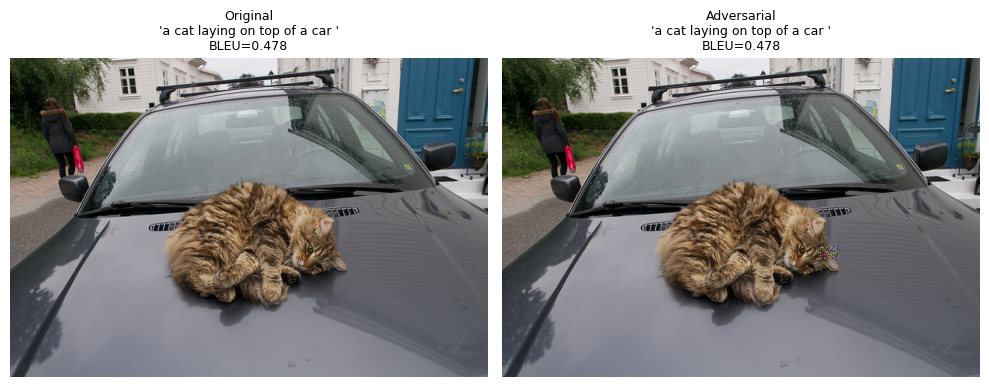

In [46]:
result = run_loss_attack(
    idx=ATTACK_IDX,
    candidate_pixels=candidate_pixels,
    pop_size=20,
    generations=20,
    F=0.6,
    CR=0.7,
    eps=40.0,
    lambda_reg=0.000,
)

base_img = result["base_img"]
adv_img = result["adv_img"]
base_caption = result["base_caption"]
adv_caption = result["adv_caption"]
base_bleu = result["base_bleu"]
adv_bleu = result["adv_bleu"]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(base_img)
plt.title(f"Original\n'{base_caption}'\nBLEU={base_bleu:.3f}", fontsize=9)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(adv_img)
plt.title(f"Adversarial\n'{adv_caption}'\nBLEU={adv_bleu:.3f}", fontsize=9)
plt.axis("off")

plt.tight_layout()
plt.show()
